<a href="https://colab.research.google.com/github/ramonfercruz/cotacao_saca_cafe_aribica/blob/main/avalia_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikeras

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
DIRETORIO = '/content/drive/MyDrive/TCC/data/20230815'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


In [ ]:
data_frame = pd.read_excel(os.path.join(DIRETORIO,'cotacao_cafe_inrriquecida.xlsx'))
data_frame = data_frame.query('ano >= 2010')
data_frame.set_index('Data', inplace=True)
data_frame.sort_index(  inplace=True)
data_frame['diesel'].fillna(method='ffill', inplace=True)

In [ ]:
coluna_modelo = ['cafe_aribica','dolar', 'diesel', '12_MESES', 'cafe_aribica_dif',
                 #'IPCA_MES', '3_MESES', 'IPCA_6_MESES', 'IPCA_ANO', '12_MESES'
                 ]

In [ ]:
data_frame.columns

Index(['dolar', 'cafe_aribica', 'indices_preco_produtos', 'cafe_robusta',
       'ano', 'mes', 'mes.1', 'INDICE', 'IPCA_MES', '3_MESES', 'IPCA_6_MESES',
       'IPCA_ANO', '12_MESES', 'diesel', 'cafe_aribica_dif',
       'cafe_aribica_mov_quadrimestre', 'cafe_aribica_mov_semestre',
       'cafe_aribica_mov_anual', 'data_real', 'estacao_ano', 'inverno',
       'outono', 'primavera', 'verao', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September'],
      dtype='object')

In [ ]:

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [ ]:
coluum_data = [ 'April', 'August',    'December', 'February', 'January', 'July', 'June', 'March', 'May',  'November', 'October', 'September', 'inverno', 'outono', 'primavera',   'verao']

In [ ]:
lags = 4
X = make_lags(data_frame[coluna_modelo], lags, lead_time=1)
y = data_frame[['cafe_aribica']]

In [ ]:

X_meses = data_frame[coluum_data]

In [ ]:
#X = Xpd.concat([X_leg, X_meses], axis=1)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

from xgboost import XGBRegressor
import numpy as np

In [ ]:
# utlizar g GroupShuffleSplit.

In [ ]:
np.seed = 1

In [ ]:
split_time_serie = TimeSeriesSplit(n_splits=5, test_size=10)

In [ ]:
def time_serie_train_test(index_train, index_teste, X, y):
  X_train = X.iloc[index_train,:]
  X_test = X.iloc[index_teste,:]
  y_train = y.iloc[index_train]
  y_test = y.iloc[index_teste]
  return X_train, y_train.values.ravel(), X_test, y_test.values.ravel()

In [ ]:
def treina_modelo(model, i, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_train_predict = model.predict(X_train)
  y_test_predict = model.predict(X_test)
  dict_metrica = {}
  dict_metrica['modelo'] = list(model.named_steps.keys())[1]
  dict_metrica['rodada'] = i
  nome_metrica = 'mape'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_absolute_percentage_error, nome_metrica, dict_metrica)
  nome_metrica = 'mse'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_squared_error, nome_metrica, dict_metrica)
  nome_metrica = 'r2'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.r2_score, nome_metrica, dict_metrica)
  nome_metrica = 'mse_log'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_squared_log_error, nome_metrica, dict_metrica)
  nome_metrica = 'mae'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_absolute_error, nome_metrica, dict_metrica)
  nome_metrica = 'rmse'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, root_mean_squared_error, nome_metrica, dict_metrica)
  return dict_metrica

def avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrica, nome_metrica, dict_metrica: dict):
    train_metrica = metrica(y_train, y_train_predict)
    test_metrica = metrica(y_test, y_test_predict)
    dict_metrica[f'{nome_metrica}_train'] = train_metrica
    dict_metrica[f'{nome_metrica}_test'] = test_metrica
    return dict_metrica
def root_mean_squared_error(y_true, y_predict):
  return metrics.mean_squared_error(y_true, y_predict, squared=False)

In [ ]:
linhas_validas = (X.isna().sum(axis=1) == 0).values

In [ ]:
X = X.loc[linhas_validas, :]
y =  y.loc[linhas_validas]

In [ ]:
X.columns

MultiIndex([('y_lag_1',     'cafe_aribica'),
            ('y_lag_1',            'dolar'),
            ('y_lag_1',           'diesel'),
            ('y_lag_1',         '12_MESES'),
            ('y_lag_1', 'cafe_aribica_dif'),
            ('y_lag_2',     'cafe_aribica'),
            ('y_lag_2',            'dolar'),
            ('y_lag_2',           'diesel'),
            ('y_lag_2',         '12_MESES'),
            ('y_lag_2', 'cafe_aribica_dif'),
            ('y_lag_3',     'cafe_aribica'),
            ('y_lag_3',            'dolar'),
            ('y_lag_3',           'diesel'),
            ('y_lag_3',         '12_MESES'),
            ('y_lag_3', 'cafe_aribica_dif'),
            ('y_lag_4',     'cafe_aribica'),
            ('y_lag_4',            'dolar'),
            ('y_lag_4',           'diesel'),
            ('y_lag_4',         '12_MESES'),
            ('y_lag_4', 'cafe_aribica_dif')],
           )

In [ ]:
pipe_rf = Pipeline([('scaler', StandardScaler()), (' RandomForest', RandomForestRegressor(n_estimators=50))])
pipe_ab = Pipeline([('scaler', StandardScaler()), (' AdaBoost', AdaBoostRegressor(n_estimators=50))])
pipe_xg = Pipeline([('scaler', StandardScaler()), (' XGB', XGBRegressor(n_estimators=500))])
pipe_dmm =  Pipeline([('scaler', StandardScaler()), (' Dumm', DummyRegressor())])
pipe_linear =  Pipeline([('scaler', StandardScaler()), (' linear', LinearRegression())])
pipe_xgboost_linear = Pipeline([('scaler', StandardScaler()), (' XGB_linear', XGBRegressor(n_estimators=100, booster='gblinear'))])


SVR
metricas = []
for i, (index_train, index_teste) in enumerate(split_time_serie.split(X)):
  print(i)
  X_train, y_train, X_test, y_test = time_serie_train_test(index_train, index_teste, X, y)
  metricas.append(treina_modelo(pipe_rf, i, X_train, y_train, X_test, y_test))
  metricas.append(treina_modelo(pipe_ab, i, X_train, y_train, X_test, y_test))
  metricas.append(treina_modelo(pipe_xg, i, X_train, y_train, X_test, y_test))
  #metricas.append(treina_modelo(pipe_dmm, i, X_train, y_train, X_test, y_test))
  metricas.append(treina_modelo(pipe_linear, i, X_train, y_train, X_test, y_test))
  metricas.append(treina_modelo(pipe_xgboost_linear, i, X_train, y_train, X_test, y_test))



0
1
2
3
4


In [ ]:
df_metrica = pd.DataFrame(metricas)

In [ ]:
df_metrica

,modelo,rodada,mape_train,mape_test,mse_train,mse_test,r2_train,r2_test,mse_log_train,mse_log_test,mae_train,mae_test,rmse_train,rmse_test
0,RandomForest,0,0.017587,0.042422,9.845601e+01,499.747874,0.981803,0.176285,5.993959e-04,0.002746,7.156067,17.749120,9.922500,22.355041
1,AdaBoost,0,0.027287,0.044941,1.722718e+02,520.205914,0.968160,0.142565,1.056700e-03,0.002853,11.085622,19.163537,13.125235,22.808023
2,XGB,0,0.000001,0.044156,5.104790e-07,777.518007,1.000000,-0.281552,3.228056e-12,0.004304,0.000508,19.113916,0.000714,27.884010
3,linear,0,0.039143,0.043704,4.367211e+02,545.468588,0.919285,0.100925,2.565738e-03,0.002957,16.173337,18.576178,20.897873,23.355269
4,XGB_linear,0,0.039456,0.039093,4.482458e+02,481.038689,0.917155,0.207123,2.629572e-03,0.002568,16.282598,16.752382,21.171816,21.932594
5,RandomForest,1,0.016063,0.100037,8.461628e+01,4403.622062,0.983013,-1.856660,5.035743e-04,0.016005,6.629566,55.994720,9.198711,66.359793
6,AdaBoost,1,0.028462,0.096494,2.005557e+02,4323.271664,0.959739,-1.804536,1.167447e-03,0.015714,11.731689,54.193912,14.161770,65.751591
7,XGB,1,0.000001,0.116989,5.200220e-07,5711.581038,1.000000,-2.705142,3.520837e-12,0.021509,0.000535,65.051185,0.000721,75.575003
8,linear,1,0.039460,0.093624,4.404990e+02,3156.838102,0.911571,-1.047863,2.563164e-03,0.011423,16.337342,50.026625,20.988069,56.185746
9,XGB_linear,1,0.039392,0.093669,4.498137e+02,3214.488491,0.909701,-1.085261,2.614229e-03,0.011653,16.307682,49.825636,21.208811,56.696459


In [ ]:
df_metrica.groupby(['modelo']).agg(media_mape_test=('mape_test', 'mean'),
                                               media_mape_train=('mape_train', 'mean'),
                                               media_mse_test=('mse_test', 'mean'),
                                               media_mse_train=('mse_train', 'mean'),
                                               media_r2_test=('r2_test', 'mean'),
                                               media_r2_train=('r2_train', 'mean'),
                                               media_mse_log_test=('mse_log_test', 'mean'),
                                               media_mse_log_train=('mse_log_train', 'mean'))

,media_mape_test,media_mape_train,media_mse_test,media_mse_train,media_r2_test,media_r2_train,media_mse_log_test,media_mse_log_train
modelo,,,,,,,,
AdaBoost,0.172606,0.035133,58727.755559,3.567355e+02,-2.653164,0.971533,0.080008,1.960521e-03
RandomForest,0.174651,0.017752,59312.246419,1.480285e+02,-2.560836,0.987058,0.084840,6.053473e-04
XGB,0.152824,0.000001,49890.422761,5.074781e-07,-1.665944,1.000000,0.078654,3.207955e-12
XGB_linear,0.067337,0.042505,6220.983504,6.663619e+02,-0.059125,0.935994,0.007124,3.090213e-03
linear,0.067898,0.042315,6489.762148,6.405670e+02,-0.113939,0.937981,0.007515,3.029262e-03


In [ ]:
df_lstm = pd.DataFrame([{'mape_test': 0.04896608769074477, 'mse_test': 1344.2117417150034, 'r2_test': 0.3678339922095185, 'mse_log_test': 0.005812754389778902, 'mae_test': 23.788180908203117, 'rmse_test': 36.663493310308056}, {'mape_test': 0.07872944768471841, 'mse_test': 2336.2993909135234, 'r2_test': -1.0408915818012936, 'mse_log_test': 0.007948759752661063, 'mae_test': 43.99052795410156, 'rmse_test': 48.335281016184474}, {'mape_test': 0.13203304258909168, 'mse_test': 16962.256828550395, 'r2_test': 0.47791635135204236, 'mse_log_test': 0.021247337228080768, 'mae_test': 119.93416601562504, 'rmse_test': 130.2392292228052}, {'mape_test': 0.10100878257582062, 'mse_test': 24947.478751211434, 'r2_test': -2.474486217040139, 'mse_log_test': 0.012775583588840914, 'mae_test': 132.14196240234378, 'rmse_test': 157.9477089140942}, {'mape_test': 0.028007141001761993, 'mse_test': 1232.7938229525396, 'r2_test': 0.8787764503203565, 'mse_log_test': 0.0011806161459193688, 'mae_test': 28.47410986328117, 'rmse_test': 35.11116379376422}])

In [ ]:
df_lstm = pd.DataFrame([{'mape_test': 0.0494051469310432,
  'mse_test': 1365.5745588320651,
  'r2_test': 0.3577873259046841,
  'mse_log_test': 0.005912035400179595,
  'mae_test': 24.00457800292968,
  'rmse_test': 36.95368126225133},
 {'mape_test': 0.07964275891691004,
  'mse_test': 2387.8036257473454,
  'r2_test': -1.0858834863954918,
  'mse_log_test': 0.008127978330115568,
  'mae_test': 44.52386535644531,
  'rmse_test': 48.8651575843908},
 {'mape_test': 0.13269232697252292,
  'mse_test': 17215.29372776213,
  'r2_test': 0.4701280936385599,
  'mse_log_test': 0.021523434816455418,
  'mae_test': 120.63827978515629,
  'rmse_test': 131.20706432110327},
 {'mape_test': 0.1045949499799633,
  'mse_test': 26663.710169148835,
  'r2_test': -2.7135092648735877,
  'mse_log_test': 0.013575040550441116,
  'mae_test': 136.88246533203127,
  'rmse_test': 163.29026354669415},
 {'mape_test': 0.01850961092518587,
  'mse_test': 489.25693469660246,
  'r2_test': 0.9518902015689391,
  'mse_log_test': 0.0004771761728039741,
  'mae_test': 18.822927001953065,
  'rmse_test': 22.119153118883247}])

In [ ]:
df_lstm['modelo'] = 'LSTM'
df_lstm['rodada'] = [0,1,2,3,4]

In [ ]:
df_lstm

,mape_test,mse_test,r2_test,mse_log_test,mae_test,rmse_test,modelo,rodada
0,0.049405,1365.574559,0.357787,0.005912,24.004578,36.953681,LSTM,0
1,0.079643,2387.803626,-1.085883,0.008128,44.523865,48.865158,LSTM,1
2,0.132692,17215.293728,0.470128,0.021523,120.638280,131.207064,LSTM,2
3,0.104595,26663.710169,-2.713509,0.013575,136.882465,163.290264,LSTM,3
4,0.018510,489.256935,0.951890,0.000477,18.822927,22.119153,LSTM,4


In [ ]:
df_metrica_final = pd.concat([df_metrica,df_lstm])

In [ ]:
df_metrica_final

,modelo,rodada,mape_train,mape_test,mse_train,mse_test,r2_train,r2_test,mse_log_train,mse_log_test,mae_train,mae_test,rmse_train,rmse_test
0,RandomForest,0,0.017587,0.042422,9.845601e+01,499.747874,0.981803,0.176285,5.993959e-04,0.002746,7.156067,17.749120,9.922500,22.355041
1,AdaBoost,0,0.027287,0.044941,1.722718e+02,520.205914,0.968160,0.142565,1.056700e-03,0.002853,11.085622,19.163537,13.125235,22.808023
2,XGB,0,0.000001,0.044156,5.104790e-07,777.518007,1.000000,-0.281552,3.228056e-12,0.004304,0.000508,19.113916,0.000714,27.884010
3,linear,0,0.039143,0.043704,4.367211e+02,545.468588,0.919285,0.100925,2.565738e-03,0.002957,16.173337,18.576178,20.897873,23.355269
4,XGB_linear,0,0.039456,0.039093,4.482458e+02,481.038689,0.917155,0.207123,2.629572e-03,0.002568,16.282598,16.752382,21.171816,21.932594
5,RandomForest,1,0.016063,0.100037,8.461628e+01,4403.622062,0.983013,-1.856660,5.035743e-04,0.016005,6.629566,55.994720,9.198711,66.359793
6,AdaBoost,1,0.028462,0.096494,2.005557e+02,4323.271664,0.959739,-1.804536,1.167447e-03,0.015714,11.731689,54.193912,14.161770,65.751591
7,XGB,1,0.000001,0.116989,5.200220e-07,5711.581038,1.000000,-2.705142,3.520837e-12,0.021509,0.000535,65.051185,0.000721,75.575003
8,linear,1,0.039460,0.093624,4.404990e+02,3156.838102,0.911571,-1.047863,2.563164e-03,0.011423,16.337342,50.026625,20.988069,56.185746
9,XGB_linear,1,0.039392,0.093669,4.498137e+02,3214.488491,0.909701,-1.085261,2.614229e-03,0.011653,16.307682,49.825636,21.208811,56.696459


In [ ]:
df_metrica_final.columns

Index(['modelo', 'rodada', 'mape_train', 'mape_test', 'mse_train', 'mse_test',
       'r2_train', 'r2_test', 'mse_log_train', 'mse_log_test', 'mae_train',
       'mae_test', 'rmse_train', 'rmse_test'],
      dtype='object')

In [ ]:
df_metrica_final_group = df_metrica_final.groupby(['modelo']).agg(media_mape_test=('mape_test', 'mean'),
                                          #media_mape_train=('mape_train', 'mean'),
                                          media_mse_test=('mse_test', 'mean'),
                                          #media_mse_train=('mse_train', 'mean'),
                                          media_r2_test=('r2_test', 'mean'),
                                          #media_r2_train=('r2_train', 'mean'),
                                          media_mse_log_test=('mse_log_test', 'mean'),
                                          #media_mse_log_train=('mse_log_train', 'mean'),
                                          media_mae_train=('mae_test', 'mean'),
                                          media_rmse_train=('rmse_test', 'mean'),
                                         )
df_metrica_final_group

,media_mape_test,media_mse_test,media_r2_test,media_mse_log_test,media_mae_train,media_rmse_train
modelo,,,,,,
AdaBoost,0.176015,62233.841423,-2.728227,0.087772,167.990876,191.655569
RandomForest,0.167904,55859.112086,-2.138138,0.079906,160.269884,179.276401
XGB,0.152831,49893.109687,-1.666394,0.078659,141.706700,160.857776
XGB_linear,0.067299,6225.556998,-0.059370,0.007133,58.650380,72.870214
linear,0.067898,6489.762148,-0.113939,0.007515,58.982119,74.497537
LSTM,0.076969,9624.327803,-0.403917,0.009923,68.974423,80.487064


In [ ]:
df_metrica_final_group.to_csv(os.path.join(DIRETORIO, 'metricas_agregada.csv'), sep=';', decimal=',')

In [ ]:
df_metrica_final.to_csv(os.path.join(DIRETORIO, 'metricas.csv'), sep=';', decimal=',')

In [ ]:
pipe_xgboost_linear.fit(X_train, y_train)
y_train_predict = pipe_xgboost_linear.predict(X_train)
y_pred = pipe_xgboost_linear.predict(X_test)

In [ ]:
scaler_y = None
def reshape_y(y, scaler_y):
  return y.reshape(1, -1)[0]

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
y_pred

array([1209.3313 , 1097.6771 ,  937.66547, 1003.1631 ,  979.3456 ,
       1137.5078 , 1062.7021 , 1107.3048 ,  991.0928 ,  904.16064],
      dtype=float32)

In [ ]:

def compara_treino_teste(y, y_train_predict, y_pred, scaler_y, test_y):
    train_size = len(y_train_predict)
    y_size = len(y)
    test_size = len(test_y)

    plt.figure(figsize=(10, 3))
    ax = sns.lineplot(y=y.cafe_aribica, x=range(y_size), color='#ff7f0e',label='Valor real')
    ax1 = sns.lineplot(y=reshape_y(y_train_predict, scaler_y), x=range(train_size), linestyle='--', color='#17becf', label='Predição treino')
    ax2 = sns.lineplot(y=reshape_y(y_pred, scaler_y), x=range(train_size, train_size + test_size), linestyle=':', color='#1f77b4',label='Predição Teste')
    ax.set_ylabel('Cotação Café')
    ax.set_xlabel('Período')

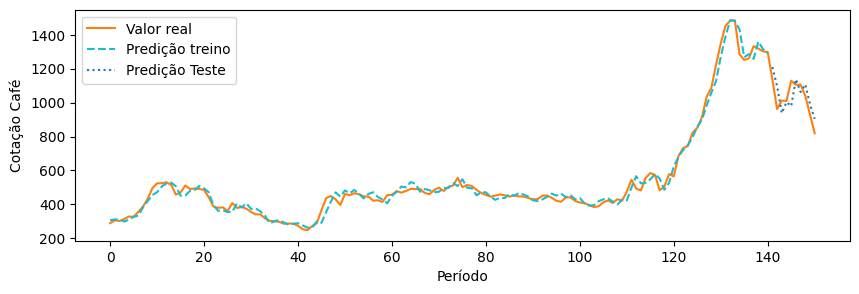

In [ ]:
compara_treino_teste(y, y_train_predict, y_pred, scaler_y, y_test)

In [ ]:
coeficiente = pipe_linear.coef_

In [ ]:
coeficiente[0]

1.200342159972135

In [ ]:
pipe_linear.intercept_

91.70590940647884

In [ ]:
for i , (lag, coluna) in  enumerate(X_train.columns):
  print(coluna, lag , coeficiente[i])

cafe_aribica y_lag_1 1.200342159972135
dolar y_lag_1 29.391216479374247
diesel y_lag_1 65.35446153490706
INDICE y_lag_1 -0.3504993333022619
IPCA_MES y_lag_1 -2555.7941149641156
3_MESES y_lag_1 1822.8617173905775
IPCA_6_MESES y_lag_1 697.307432107743
IPCA_ANO y_lag_1 0.2667243368179819
12_MESES y_lag_1 13.18024723508668
cafe_aribica y_lag_2 -0.19708267856783754
dolar y_lag_2 -57.9792467157208
diesel y_lag_2 -39.89437826230454
INDICE y_lag_2 0.26922752465137745
IPCA_MES y_lag_2 -1179.3581338417202
3_MESES y_lag_2 -1372.6629211876964
IPCA_6_MESES y_lag_2 -4.71282804025298
IPCA_ANO y_lag_2 3.120573807260087
12_MESES y_lag_2 -10.040539546808668
cafe_aribica y_lag_3 0.0723181931429843
dolar y_lag_3 36.574499765406536
diesel y_lag_3 28.04125354743986
INDICE y_lag_3 1.0357537579919731
IPCA_MES y_lag_3 -1268.0024321939948
3_MESES y_lag_3 61.347195881691775
IPCA_6_MESES y_lag_3 2.1898430642802653
IPCA_ANO y_lag_3 -4.107163705854482
12_MESES y_lag_3 18.156760596504586
cafe_aribica y_lag_4 -0.1462

In [ ]:
coeficiente

array([ 1.20034216e+00,  2.93912165e+01,  6.53544615e+01, -3.50499333e-01,
       -2.55579411e+03,  1.82286172e+03,  6.97307432e+02,  2.66724337e-01,
        1.31802472e+01, -1.97082679e-01, -5.79792467e+01, -3.98943783e+01,
        2.69227525e-01, -1.17935813e+03, -1.37266292e+03, -4.71282804e+00,
        3.12057381e+00, -1.00405395e+01,  7.23181931e-02,  3.65744998e+01,
        2.80412535e+01,  1.03575376e+00, -1.26800243e+03,  6.13471959e+01,
        2.18984306e+00, -4.10716371e+00,  1.81567606e+01, -1.46264829e-01,
        1.06058140e+01, -5.10598972e+01, -9.76170000e-01,  1.34602912e+03,
       -7.46260479e+02, -1.69314668e+00, -1.99214018e+00, -1.44967433e+01])

In [ ]:
validacao_cruzada = []
y['Corte'] = 'Treinamento'
for i , (train_index, test_index) in enumerate(split_time_serie.split(X)):
  grupo = i + 1
  y.iloc[test_index, 1] = f'{grupo}º Corte'


Text(0.5, 0, 'Período')

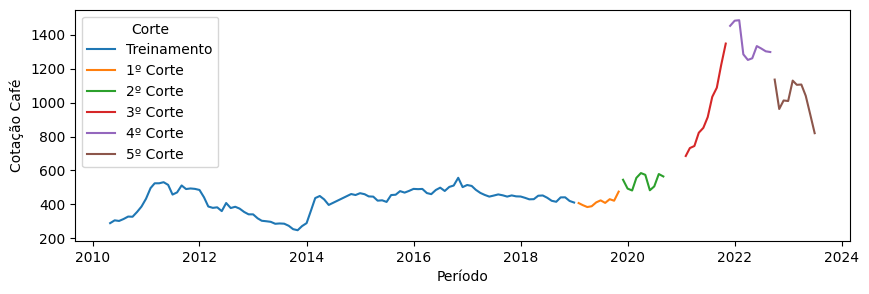

In [ ]:
plt.figure(figsize=(10, 3))
ax = sns.lineplot(y=y.cafe_aribica, x=y.index, hue=y.Corte)
ax.set_ylabel('Cotação Café')
ax.set_xlabel('Período')

In [ ]:
"""

A Tabela 2 mostra resultados análogos onde redes neurais foram usadas para previsão.
Os experimentos confirmam essencialmente as descobertas dos modelos lineares. Se apenas um valor defasado
é utilizado, o procedimento de ajuste do modelo apresenta dificuldades e os modelos resultantes não são competitivos,
produzindo altos valores de MAPAE e MPAE em todos os procedimentos de seleção de modelos e
experimentos.
Para o primeiro experimento, os métodos CV apresentam vantagens no sentido de que rendem mais
estimativas de erro precisas (MAPAE inferior) e um viés comparável (conforme medido pelo MPAE) em comparação
ao procedimento OOS.
Essas vantagens também são vistas no Experimento 2. Para o Experimento 3, onde os modelos são fortemente
mal especificado, as vantagens dos procedimentos CV para o MAPAE praticamente desapareceram e o
prevalecem as desvantagens do alto viés.
""".replace('\n', ' ')


'  A Tabela 2 mostra resultados análogos onde redes neurais foram usadas para previsão. Os experimentos confirmam essencialmente as descobertas dos modelos lineares. Se apenas um valor defasado é utilizado, o procedimento de ajuste do modelo apresenta dificuldades e os modelos resultantes não são competitivos, produzindo altos valores de MAPAE e MPAE em todos os procedimentos de seleção de modelos e experimentos. Para o primeiro experimento, os métodos CV apresentam vantagens no sentido de que rendem mais estimativas de erro precisas (MAPAE inferior) e um viés comparável (conforme medido pelo MPAE) em comparação ao procedimento OOS. Essas vantagens também são vistas no Experimento 2. Para o Experimento 3, onde os modelos são fortemente mal especificado, as vantagens dos procedimentos CV para o MAPAE praticamente desapareceram e o prevalecem as desvantagens do alto viés. '

In [ ]:
validacao_cruzada

[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
  array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110])),
 (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,